# Donostia GeoEuskadi

06 April 2016 - <mquartulli@vicomtech.org>

Is the data file there?

In [1]:
! ls -l

total 1282088
-rw-r--r--  1 marcoq  staff    4427149 Apr  6 12:18 010_scikitslearn-rasterio-0.ipynb
-rw-r--r--  1 marcoq  staff    3290497 Apr  6 10:31 020_igarss2015.ipynb
-rw-r--r--  1 marcoq  staff    3242595 Apr  6 09:21 030_Sentinel2LatLonHeightPix-1.ipynb
-rw-r--r--  1 marcoq  staff    2665920 Apr  5 15:44 04_open_source_tools.ipynb
-rw-r--r--  1 marcoq  staff     436034 Apr  6 12:08 Donostia.ipynb
-rw-r-----@ 1 marcoq  staff        643 Apr  6 12:12 IGARSS_shape.dbf
-rw-r-----@ 1 marcoq  staff       1620 Apr  6 12:10 IGARSS_shape.shp
-rw-r-----@ 1 marcoq  staff        148 Apr  6 12:12 IGARSS_shape.shx
-rw-r--r--@ 1 marcoq  staff       1939 May 23  2015 README.md
lrwxr-xr-x  1 marcoq  staff         59 Apr  3 18:36 all_donosti_cropped_wgs4326.tif -> /Users/marcoq/Data/donostia/all_donosti_cropped_wgs4326.tif
-rw-r--r--@ 1 marcoq  staff      58495 Apr  4 07:24 bselogo.png
-rw-r--r--  1 marcoq  staff     699363 Apr  6 12:03 crts.ipynb
-rw-r-----@ 1 marcoq  staff     353521 Apr  6 11:

# Read data

Data from the GeoEuskadi repository

* <http://www.geo.euskadi.eus/s69-15375/es/>

Original data is .25m per pixel, RGB.

In [2]:
import pandas

In [3]:
df = pandas.read_pickle('donostia_training_igarss.pandas')

In [59]:
df.head()

f0   f1   f2        f3        f4        f5        f6     label  \
1894954   30   75   95  0.051161  0.061339  0.117377  0.610509       Sea   
2187079   30   66   89  0.042860  0.048933  0.101671  0.412995       Sea   
1537643  121  148  133  0.227073  0.269377  0.261871  0.889764       Sea   
847959    45   96  107  0.079177  0.099844  0.154159  0.196810       Sea   
435941   137  140  145  0.248041  0.261187  0.305151  0.675255  Building   

             mean_dist  
1894954   79844.737466  
2187079   85188.992413  
1537643  105047.334389  
847959    75130.236413  
435941   111650.458364

In [60]:
import IPython.display

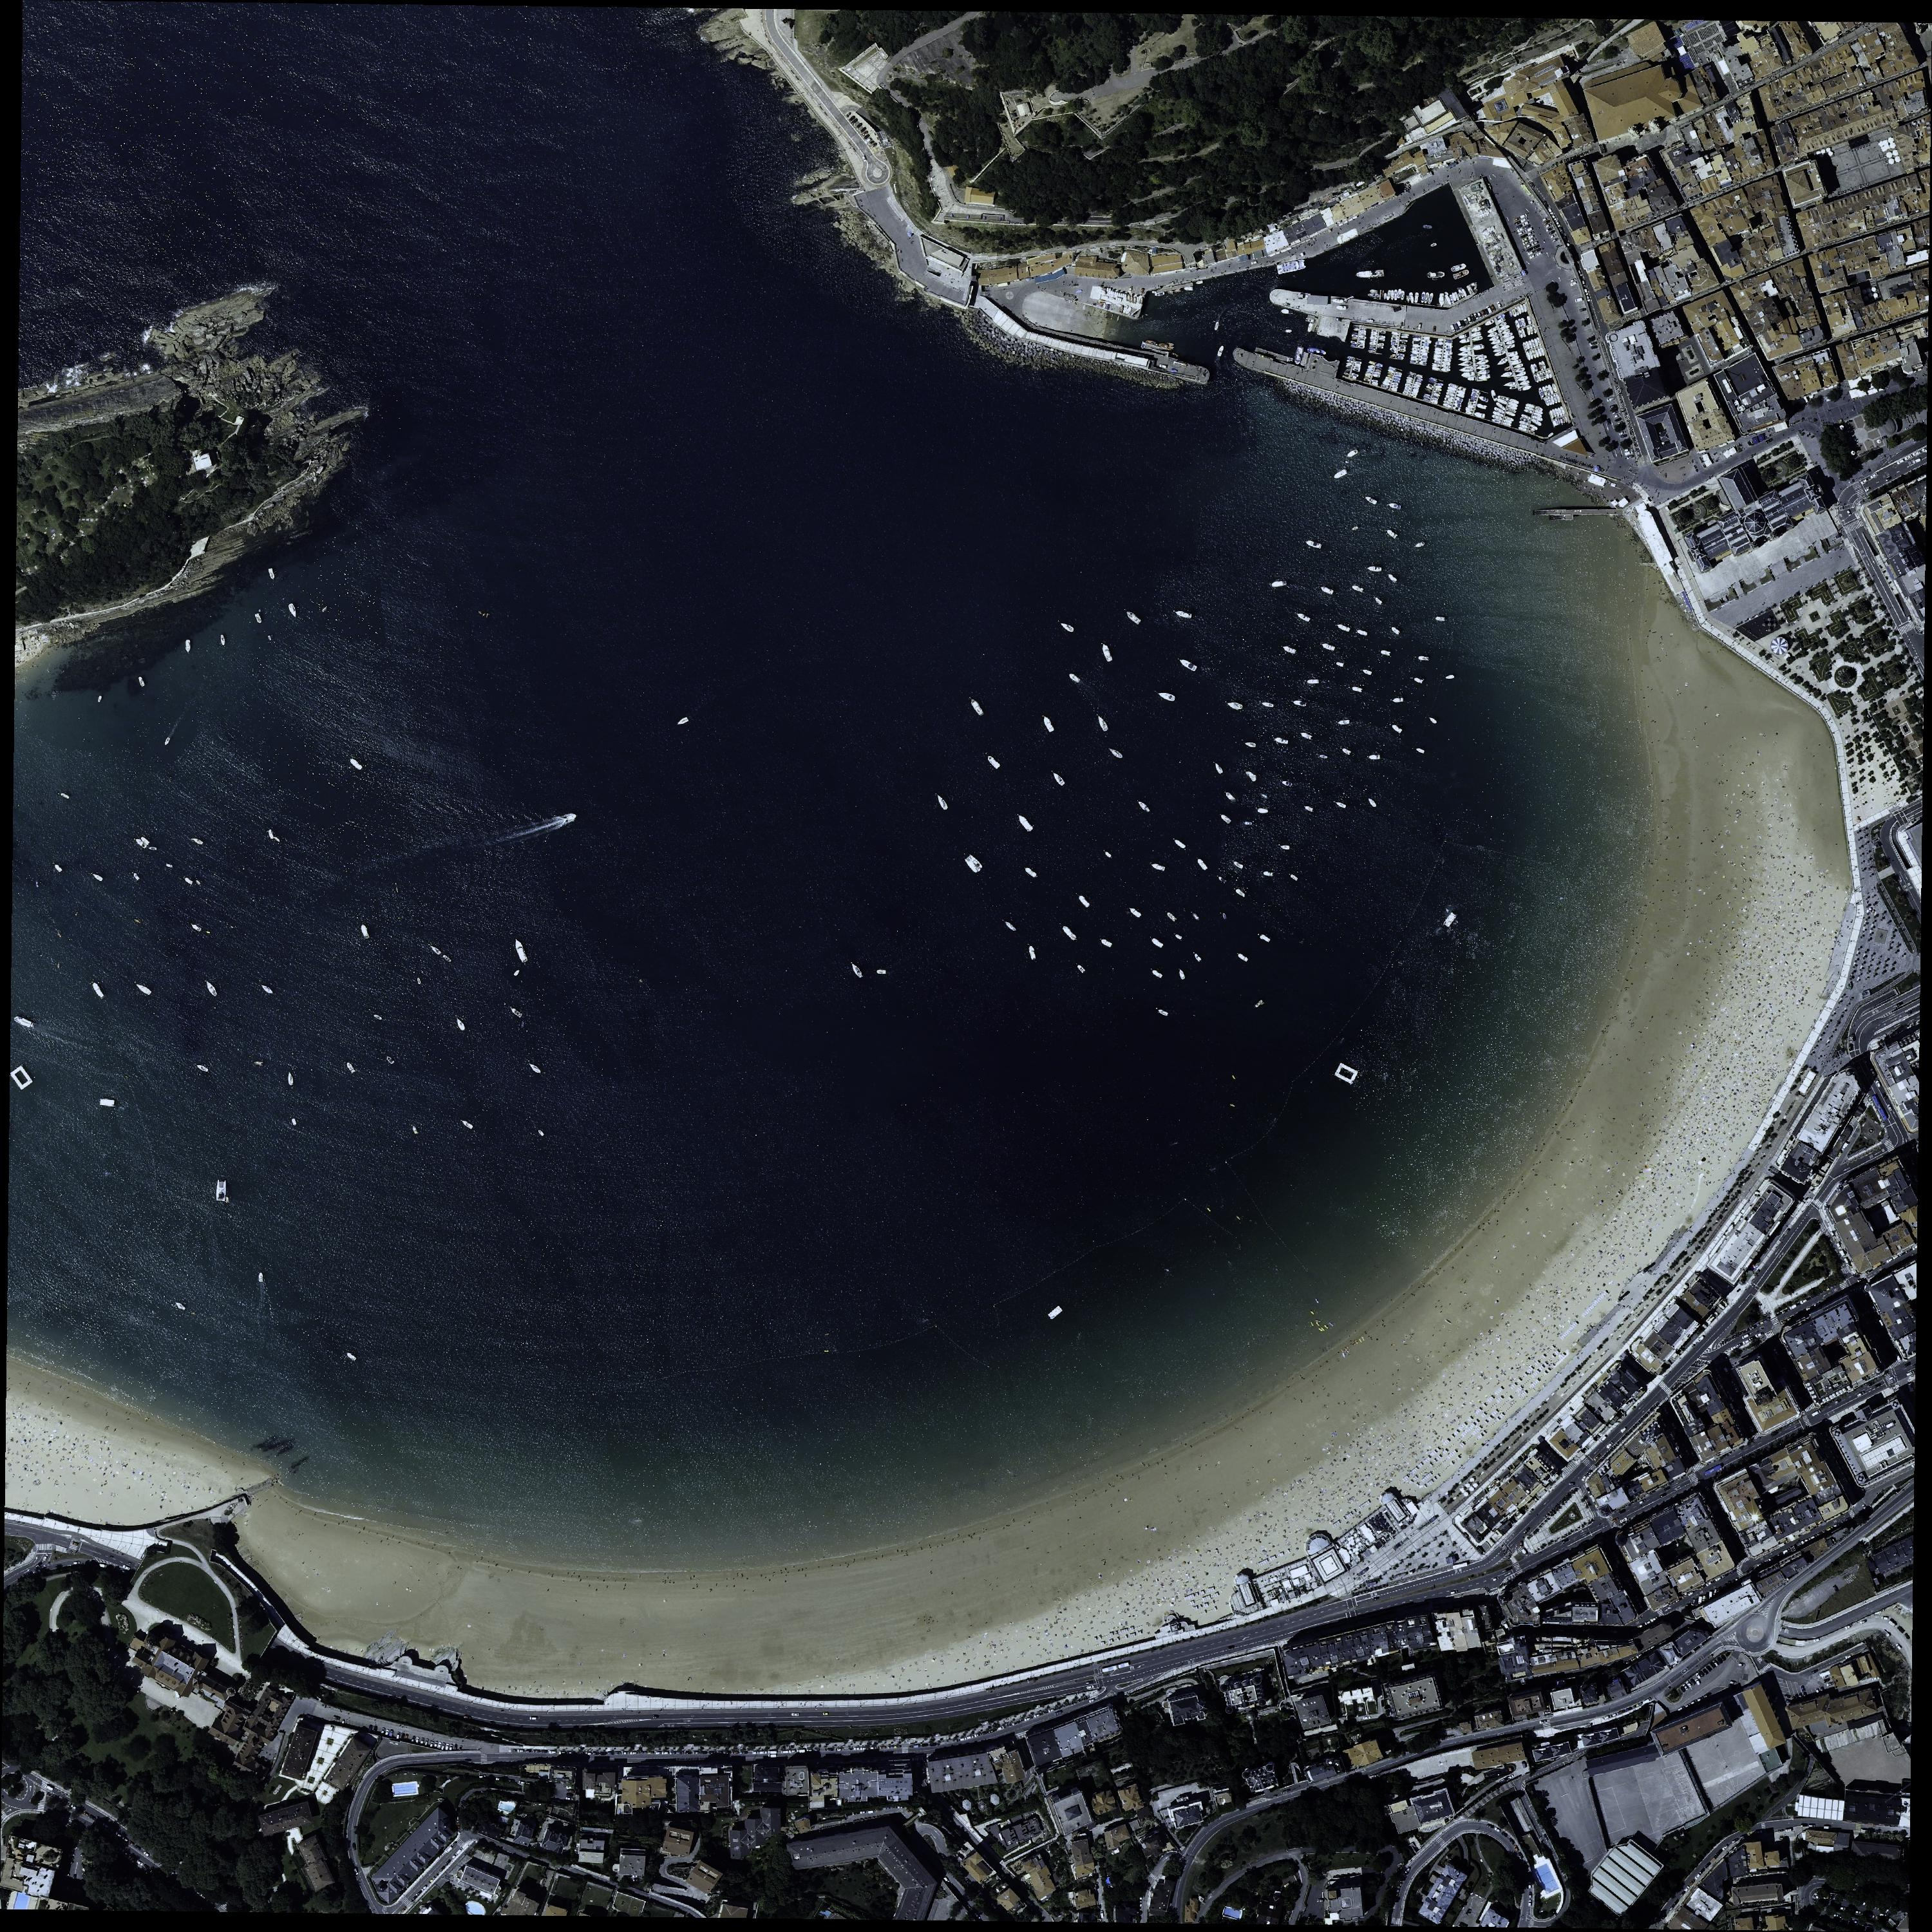

In [62]:
IPython.display.Image('donosti_hsv.jpg')

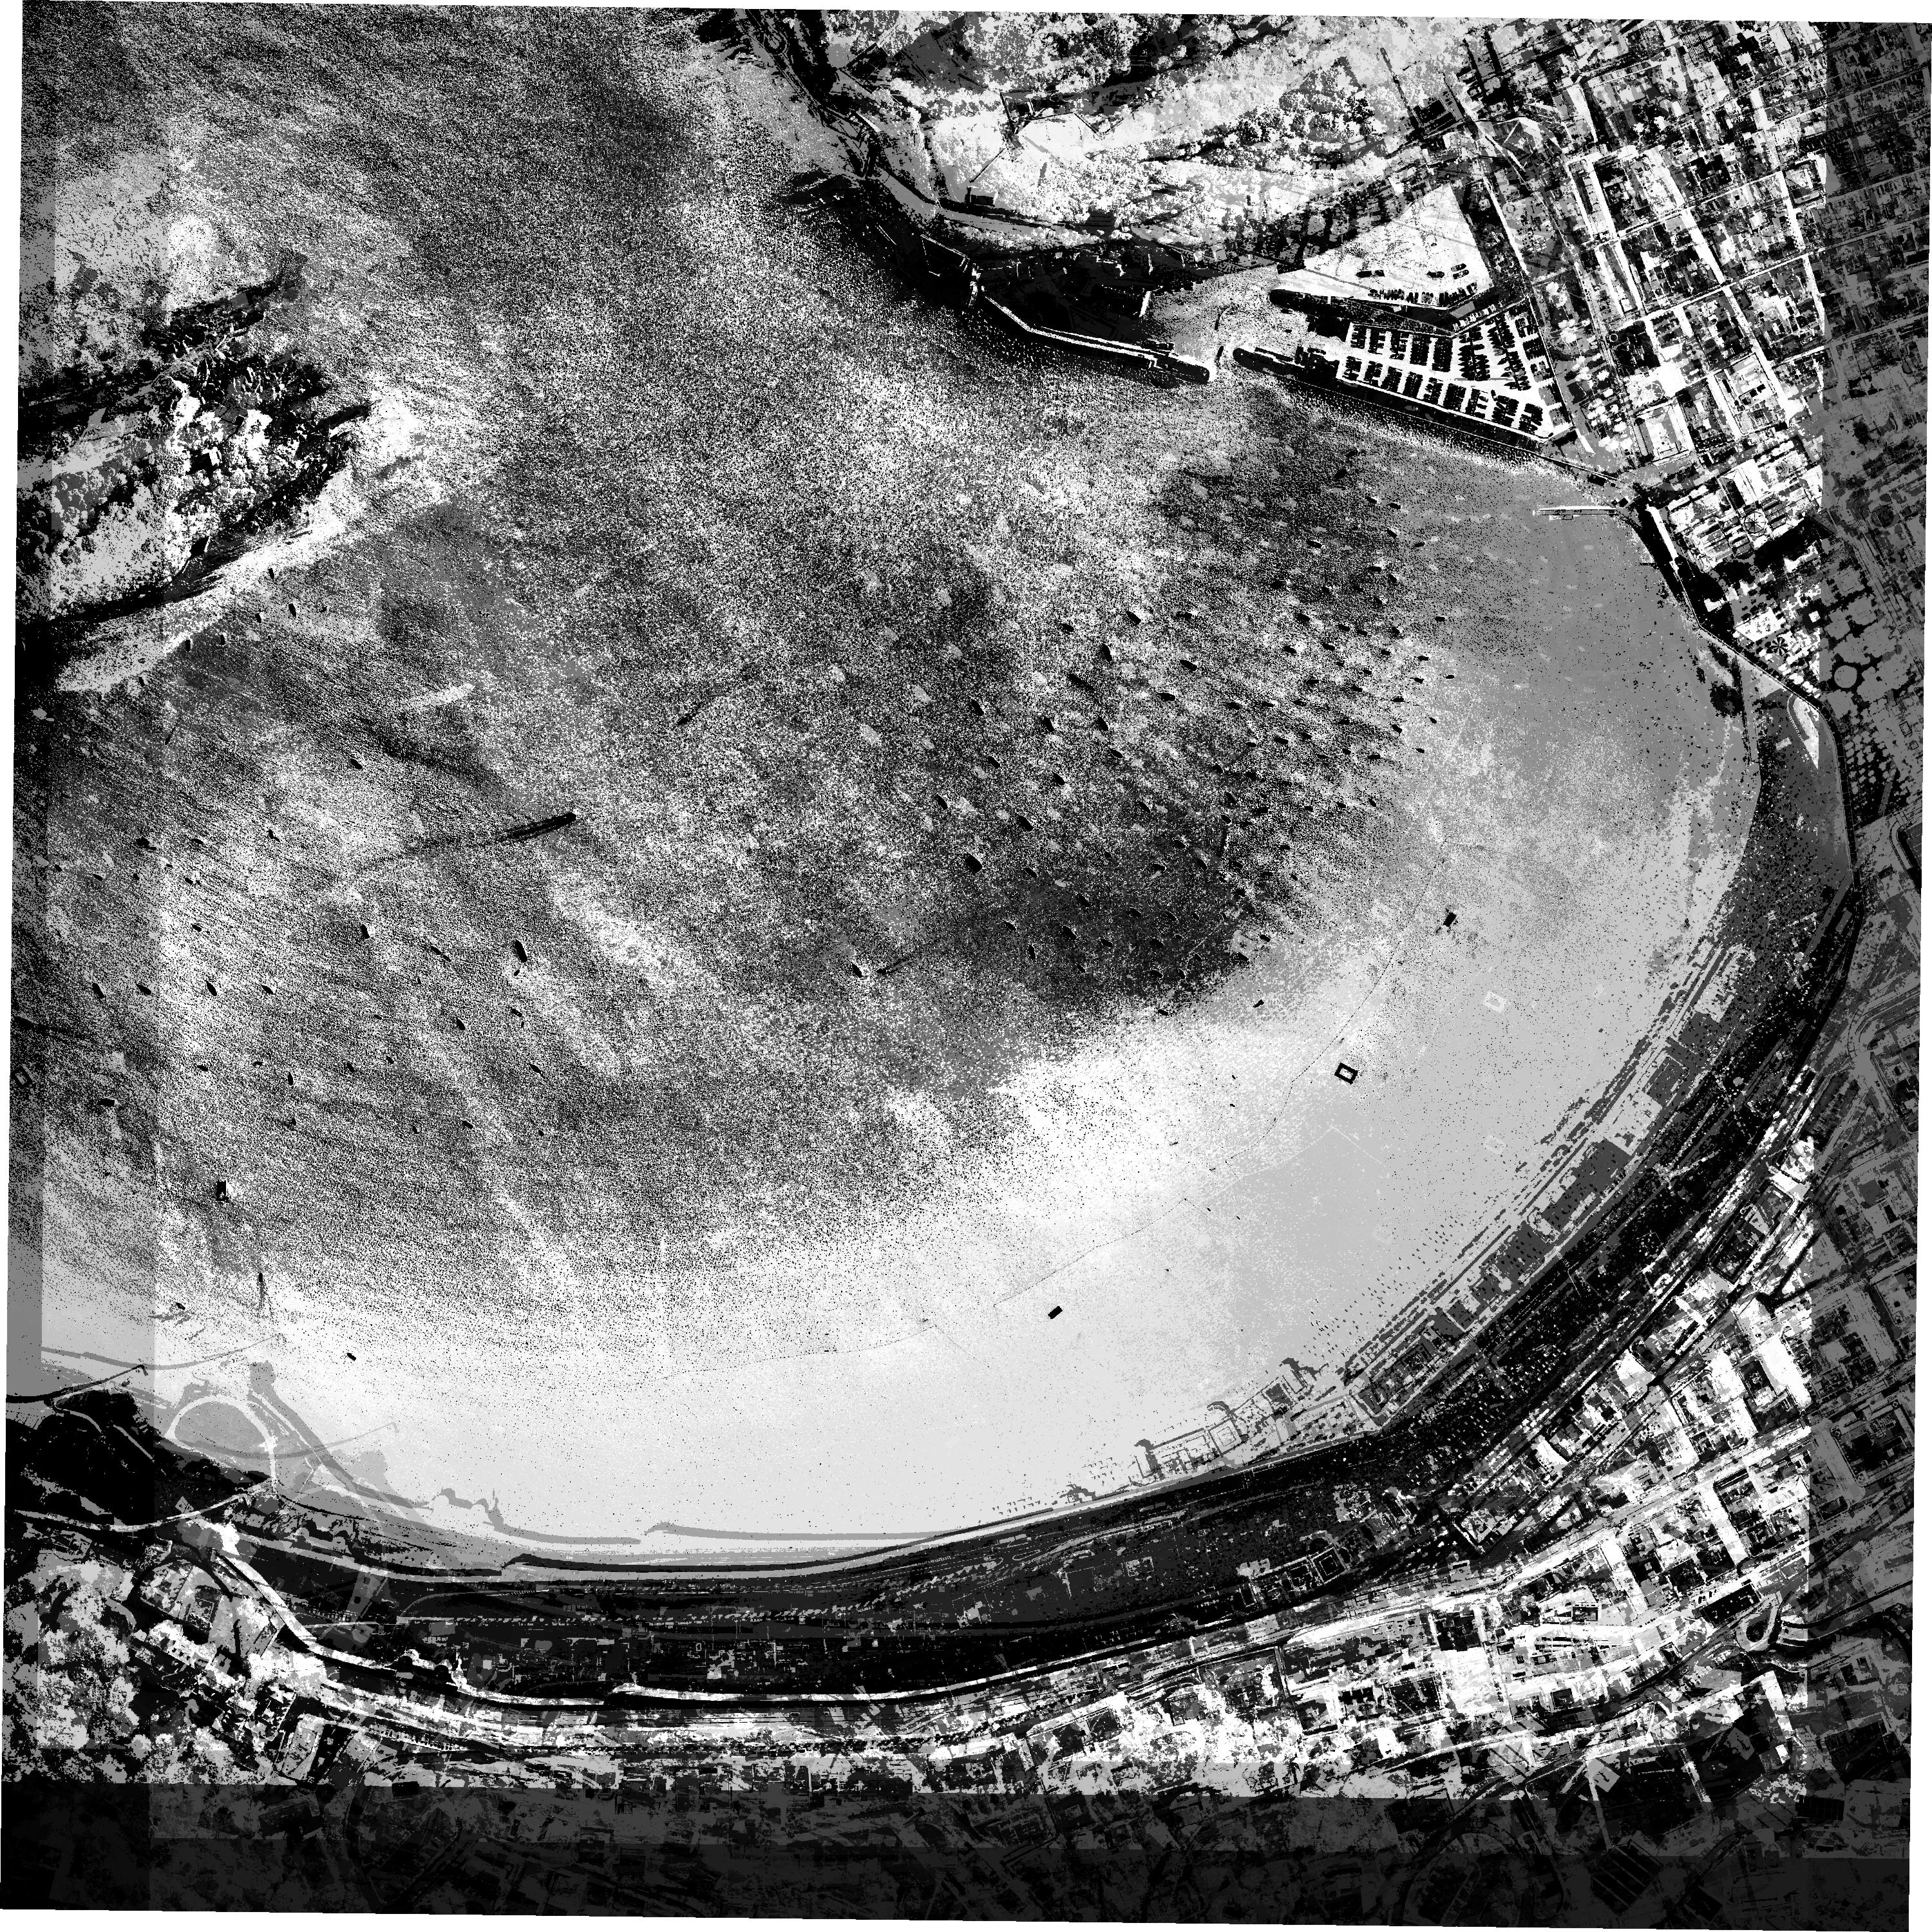

In [63]:
IPython.display.Image('donosti_lbp.jpg')

# Data filtering

In [5]:
df.shape

(2422213, 8)

In [11]:
df = df.sample(n=1000)

# Pre-process

Primitive feature extraction already carried out:

* f0-2: HSV color channels
* f3-f6: LBP texture
* label: supervised training label

For more info see `010_scikitslearn-rasterio.ipynb`

# Plot data

In [12]:
%matplotlib inline

In [13]:
from pandas.tools.plotting import scatter_matrix

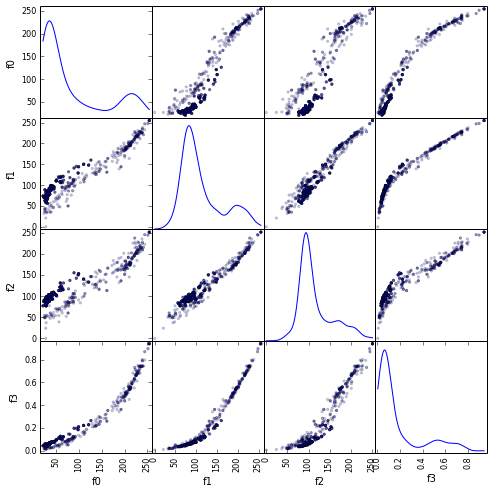

In [9]:
_ = scatter_matrix(df[df.columns[:4]], alpha=0.2, figsize=(8, 8), diagonal='kde')

Note: consider the `seaborn` library for better statistical plotting.

# Compute similarities

In [10]:
import sklearn.metrics.pairwise

In [14]:
dist = sklearn.metrics.pairwise.euclidean_distances(df[df.columns[:-1]].values)

In [15]:
dist.shape

(1000, 1000)

In [16]:
import matplotlib.pylab

<matplotlib.colorbar.Colorbar instance at 0x115d44a70>

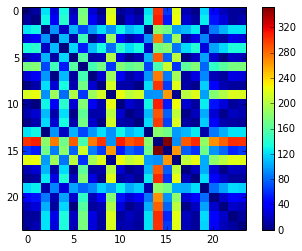

In [17]:
matplotlib.pylab.imshow(dist[:24,:24], interpolation='nearest')
matplotlib.pylab.colorbar()

# Extract outliers by integrating the similarity matrix?

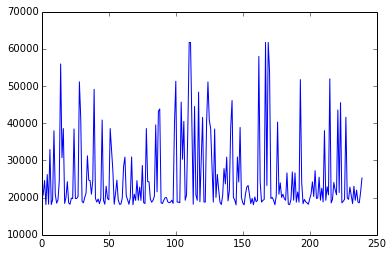

In [18]:
matplotlib.pylab.plot(dist[:240,:240].sum(axis=0))

Compute expected distance from other elements in the dataset.

In [19]:
df['mean_dist'] = dist.sum(axis=0)

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
df.head()

f0   f1   f2        f3        f4        f5        f6     label  \
1894954   30   75   95  0.051161  0.061339  0.117377  0.610509       Sea   
2187079   30   66   89  0.042860  0.048933  0.101671  0.412995       Sea   
1537643  121  148  133  0.227073  0.269377  0.261871  0.889764       Sea   
847959    45   96  107  0.079177  0.099844  0.154159  0.196810       Sea   
435941   137  140  145  0.248041  0.261187  0.305151  0.675255  Building   

             mean_dist  
1894954   79844.737466  
2187079   85188.992413  
1537643  105047.334389  
847959    75130.236413  
435941   111650.458364

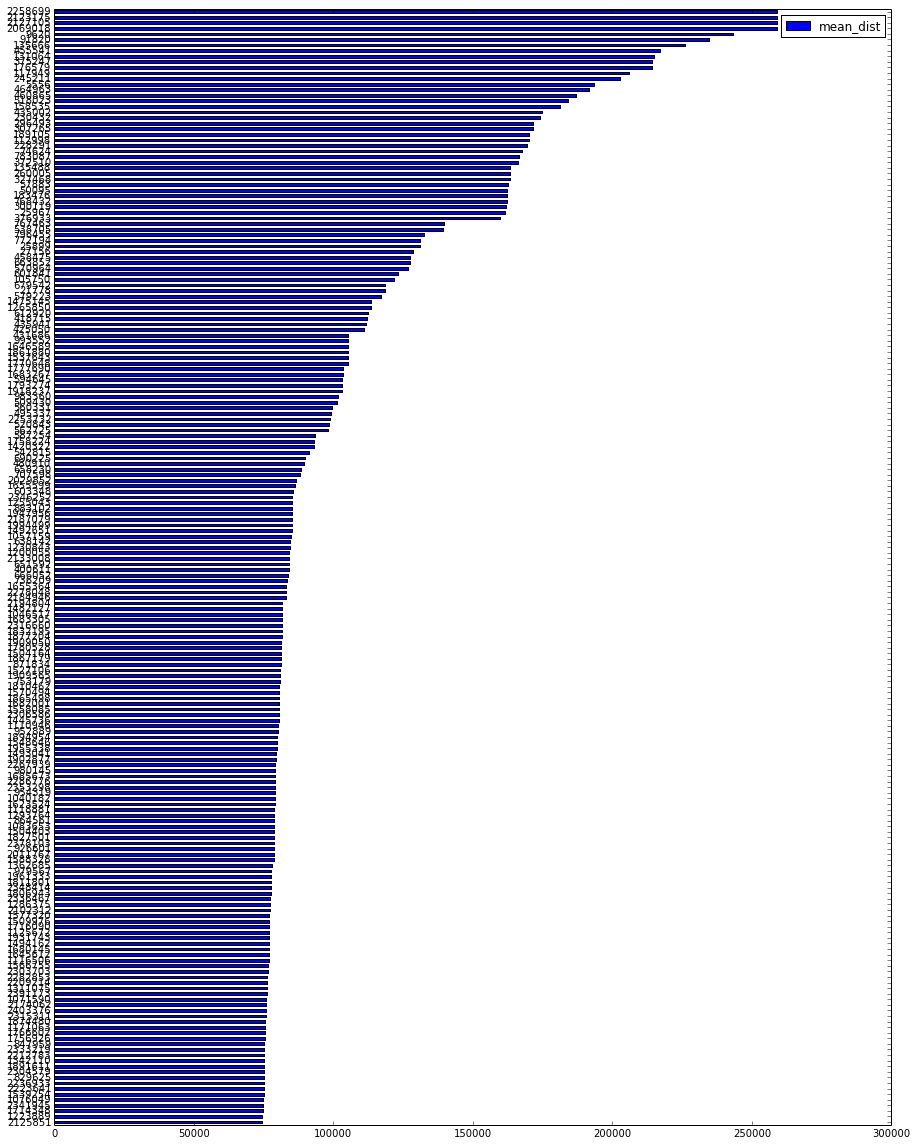

In [21]:
df.head(200).sort('mean_dist').plot(figsize=(15,20), kind='barh',y='mean_dist')

# In Spark

We try it again, this time in Spark, to understand about any differences in the way we need to think about the data.

# Start the cluster

In [22]:
import os
os.environ['SPARK_HOME'] = '/usr/local/spark-1.1.0/'
import sparklingpandas.utils
sparklingpandas.utils.add_pyspark_path()

In [23]:
import pyspark

In [24]:
conf = pyspark.conf.SparkConf()
conf.setAppName(__name__)

In [25]:
sc = pyspark.SparkContext(conf=conf)

In [26]:
sc.master

u'local[*]'

In [27]:
sc.defaultParallelism

4

# Transform the `pandas.DataFrame` to a `pyspark.RDD`

Notice that this is NOT typical. An RDD will generally be created by reading data from a distributed file system such as HDFS or from a DataBase

In [28]:
df.columns[:-1]

Index([u'f0', u'f1', u'f2', u'f3', u'f4', u'f5', u'f6', u'label'], dtype='object')

In [29]:
df[df.columns[:-1]].head()

f0   f1   f2        f3        f4        f5        f6     label
1894954   30   75   95  0.051161  0.061339  0.117377  0.610509       Sea
2187079   30   66   89  0.042860  0.048933  0.101671  0.412995       Sea
1537643  121  148  133  0.227073  0.269377  0.261871  0.889764       Sea
847959    45   96  107  0.079177  0.099844  0.154159  0.196810       Sea
435941   137  140  145  0.248041  0.261187  0.305151  0.675255  Building

In [30]:
def dataframe2dict(df):
    return { df.index.tolist()[y]:df.values[y,:] for y in range(df.values.shape[0]) }

In [31]:
dataframe2dict(df.head(2))

{1894954: array([30.0, 75.0, 95.0, 0.051161027109799126, 0.06133852700333865,
        0.1173770267991517, 0.6105092158863832, 'Sea', 79844.73746637494], dtype=object),
 2187079: array([30.0, 66.0, 89.0, 0.04285997613544386, 0.048932820290685325,
        0.1016711503833779, 0.4129949600798941, 'Sea', 85188.99241337708], dtype=object)}

### TODO: remember extending the analysis to all samples in the next block

In [32]:
N = 200

In [45]:
df_rdd = sc.parallelize(dataframe2dict(df[df.columns[:-2]].head(N)).iteritems())

# How to think about the `RDD`

It behaves a lot like a list

In [46]:
df_rdd.cartesian(df_rdd).count()

40000

In this case, a list of dictionaries

In [47]:
df_rdd.take(1)

[(1867179, array([  65.        ,  121.        ,  115.        ,    0.12110435,
            0.16035445,    0.18671987,    0.8854365 ]))]

# Compute cartesian product of item set

We need to do this to go from a linear to a matrix structure

In [48]:
df_rdd.cartesian(df_rdd).take(1)

[((1867179, array([  65.        ,  121.        ,  115.        ,    0.12110435,
             0.16035445,    0.18671987,    0.8854365 ])),
  (1867179, array([  65.        ,  121.        ,  115.        ,    0.12110435,
             0.16035445,    0.18671987,    0.8854365 ])))]

In [49]:
df_rdd.cartesian(df_rdd)\
      .map(lambda ab:(ab[0][0],ab[0][1],ab[1][1]))\
      .take(1)

[(1867179, array([  65.        ,  121.        ,  115.        ,    0.12110435,
            0.16035445,    0.18671987,    0.8854365 ]), array([  65.        ,  121.        ,  115.        ,    0.12110435,
            0.16035445,    0.18671987,    0.8854365 ]))]

We keep the ID for the first element of the couple: we will need to group distances based on it before computing the mean distance for each element.

Question: does this $O(N^2)$ procedure really make sense?

# Compute euclidean distance matrix by `map`

We keep using `sklearn` to compute the distance between to items.
Note how we can keep using the "Python Data Stack" (`numpy`, `sklearn` and more) because the interpretation is carried out by Python on the worker nodes.

In [50]:
def euclidean_distance(ab):
    import sklearn.metrics
    a = ab[1]
    b = ab[2]
    return sklearn.metrics.pairwise.distance.euclidean(a,b)

Note the `import` inside the function.

The correct yet opaque way to do this is by `sc.addPyFile(sklearn.metrics.__file__)`

In [51]:
dist_rdd = df_rdd.cartesian(df_rdd)\
                 .map(lambda ab:(ab[0][0],ab[0][1],ab[1][1]))\
                 .map(lambda x: (x[0], euclidean_distance(x)))

In [52]:
dist_rdd.take(2)

[(1867179, 0.0), (1867179, 43.232795338006241)]

# Integrate to get expectation by `reduce`

In [53]:
dist_rdd.reduceByKey(lambda x,y:x+y)\
        .map(lambda x:(x[0], x[1]/float(N)))\
        .take(2)

[(230432, 170.06885122816141), (2278048, 84.248845031083434)]

Note the reduction based on the `objID` key

# Sort

In [54]:
dist_rdd.reduceByKey(lambda x,y:x+y)\
        .map(lambda x:(x[0], x[1]/float(N)))\
        .sortBy(lambda x: x[1], ascending=False)\
        .take(3)

[(2127105, 253.64372223761347),
 (2123175, 253.64372223761347),
 (2069018, 253.64372223761347)]

# Collect top N for plotting

In [55]:
df_mean_dist = \
dist_rdd.reduceByKey(lambda x,y:x+y)\
        .map(lambda x:(x[0], x[1]/float(N)))\
        .sortBy(lambda x: x[1], ascending=False)\
        .take(N)

In [56]:
df_spark = pandas.DataFrame(df_mean_dist)
df_spark.columns = [ 'objID', 'mean_dist' ]
df_spark['objID'] = df_spark['objID'].astype('category')
df_spark.set_index('objID').head()

mean_dist
objID              
2127105  253.643722
2123175  253.643722
2069018  253.643722
2258699  253.643722
9620     238.118003

In [57]:
df_spark.shape

(200, 2)

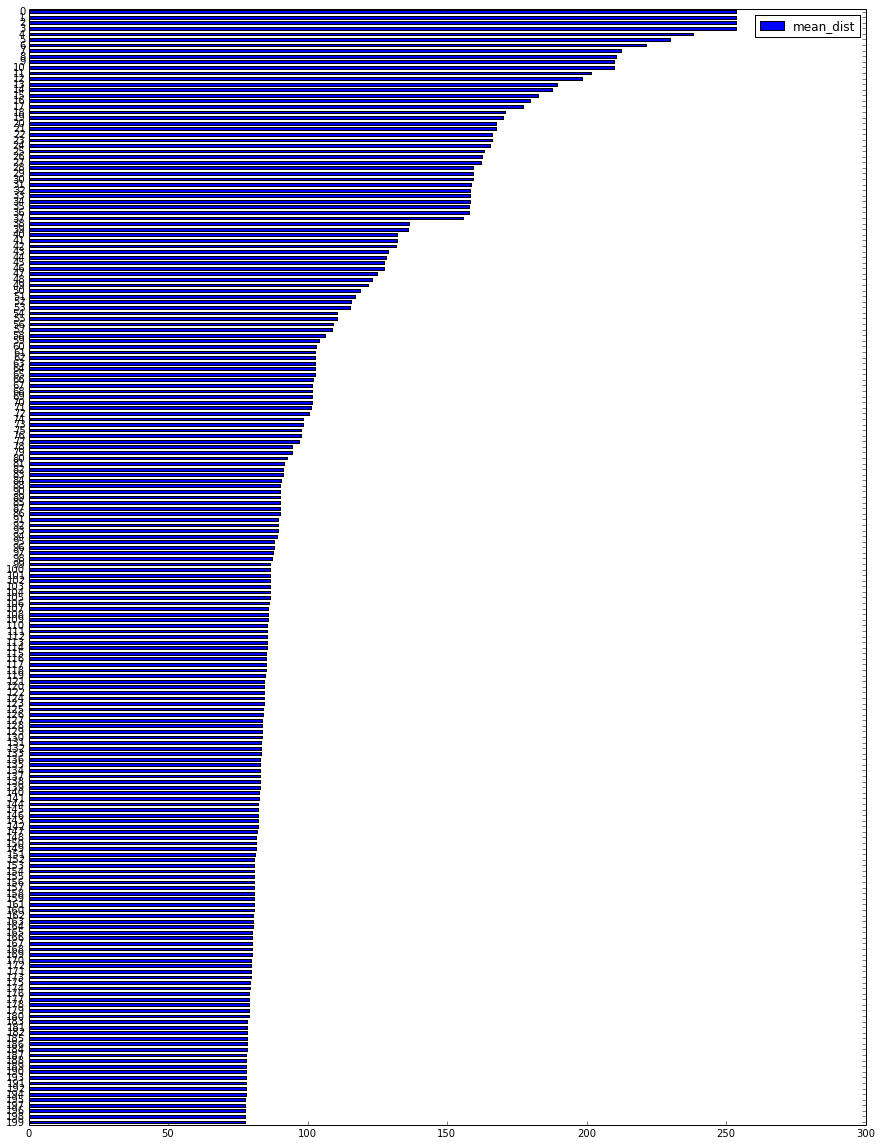

In [58]:
df_spark.sort('mean_dist').plot(figsize=(15,20), kind='barh',y='mean_dist')